# <center> Churn Prediction <center/>
    

# Premises

* The bank revenue comes from clients transactions
* We will estimate the average revenue as: 
    * 15% of the client salary, if the their salary is lower than the mean salary of all the bank clients
    * 20% of the client salary, if the their salary is greater or equal the mean salary of all the bank clients

<br>

# The Business Problem:
* Anuanly, part of the bank clients do not renew their contract
* The goal is to predict which clients are more likely to leave ( do not renew their contract)
    

<br>

# 0.0 Imports

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display       import Image
from IPython.core.display  import HTML
#from sklearn.preprocessing import OneHotEncoder

## 0.1 Functions

In [33]:
def descriptive_sts(num_attributes):
    # Central Tedency - mean, median
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    #Dispersion - str,min, max,range,skew,kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x : x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x : x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x : x.kurtosis())).T

    #Contatenate
    m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range','mean','median', 'std','skew','kurtosis']
    return m

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    

def box_dist_plots(target_col, value_col, df, bins = 10 ):
    plt.subplot(2,2,1)
    sns.boxplot(x = target_col, y = value_col, data = df)

    plt.subplot(2,2,2)
    aux = df[[ value_col]]
    sns.histplot(aux)

    plt.subplot(2,2,3)
    aux = df.loc[df[target_col] == 1 ,value_col]
    sns.histplot(aux, fill = False,element="step",bins = 10, color = 'red')

    aux = df.loc[df[target_col] == 0 , value_col]
    sns.histplot(aux, fill = False, element="step",bins = 10, color = 'green')
    plt.legend(title=value_col, labels=['1', '0'], )
    plt.title(value_col);

    plt.subplot(2,2,4)
    aux = df.loc[df[target_col] == 1 , value_col]
    sns.histplot(aux, fill = False,element="step", stat="density",bins = 10, color = 'red')

    aux = df.loc[df[target_col] == 0 , value_col]
    sns.histplot(aux, fill = False, element="step",stat="density",bins = 10, color = 'green')
    plt.legend(title=value_col, labels=['1', '0'], )
    plt.title('Normalized '+ value_col);

In [34]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Data

In [35]:
BUCKET_NAME = 'landing-zone-ds'
FILE_NAME = 'churn.csv'

In [36]:
df_raw = pd.read_csv(os.path.join('gs://', BUCKET_NAME, FILE_NAME))
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 1.0 Data Description

* RowNumber: corresponds to the record (row) number and has no effect on the output.
* CustomerId: contains random values and has no effect on customer leaving the bank.
* Surname: the surname of a customer has no impact on their decision to leave the bank.
* CreditScore: can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
* Geography: a customer’s location can affect their decision to leave the bank.
* Gender: it’s interesting to explore whether gender plays a role in a customer leaving the bank.
* Age: this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
* Tenure: refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
* Balance: also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
* NumOfProducts: refers to the number of products that a customer has purchased through the bank.
* HasCrCard: denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
* IsActiveMember: active customers are less likely to leave the bank.
* EstimatedSalary: as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.
* Exited: whether or not the customer left the bank. (0=No,1=Yes)

## 1.1 Data Dimension

In [37]:
df1 = df_raw.copy()

In [38]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 10000
Number of Columns: 14


## 1.2 Data Types

In [39]:
df1.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

## 1.3 Check NaN

In [40]:
df1.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## 1.4 Change Data Types

In [41]:
df1['CustomerId'] = df1['CustomerId'] .astype('str')

## 1.5 Descriptive Statistics

### 1.5.1 Numerical Attributes

In [42]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])

In [43]:
stats_table = descriptive_sts(num_attributes)
stats_table

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,RowNumber,1.00,10000.00,9999.00,5000.500000,5000.500,2886.751332,0.000000,-1.200000
1,CreditScore,350.00,850.00,500.00,650.528800,652.000,96.648466,-0.071607,-0.425726
2,Age,18.00,92.00,74.00,38.921800,37.000,10.487282,1.011320,1.395347
3,Tenure,0.00,10.00,10.00,5.012800,5.000,2.892030,0.010991,-1.165225
4,Balance,0.00,250898.09,250898.09,76485.889288,97198.540,62394.285254,-0.141109,-1.489412
5,NumOfProducts,1.00,4.00,3.00,1.530200,1.000,0.581625,0.745568,0.582981
6,HasCrCard,0.00,1.00,1.00,0.705500,1.000,0.455818,-0.901812,-1.186973
7,IsActiveMember,0.00,1.00,1.00,0.515100,1.000,0.499772,-0.060437,-1.996747
8,EstimatedSalary,11.58,199992.48,199980.90,100090.239881,100193.915,57507.617221,0.002085,-1.181518
9,Exited,0.00,1.00,1.00,0.203700,0.000,0.402748,1.471611,0.165671


In [44]:
num_attributes.describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

,RowNumber,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
5%,500.95000,489.000000,25.000000,1.000000,0.000000,1.000000,0.00000,0.000000,9851.818500,0.000000
25%,2500.75000,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
90%,9000.10000,778.000000,53.000000,9.000000,149244.792000,2.000000,1.00000,1.000000,179674.704000,1.000000
95%,9500.05000,812.000000,60.000000,9.000000,162711.669000,2.000000,1.00000,1.000000,190155.375500,1.000000


### 1.5.2 categorical Attributes

In [45]:
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])

In [46]:
cat_attributes.apply(lambda x: x.unique())

CustomerId    [15634602, 15647311, 15619304, 15701354, 15737...
Surname       [Hargrave, Hill, Onio, Boni, Mitchell, Chu, Ba...
Geography                              [France, Spain, Germany]
Gender                                           [Female, Male]
dtype: object

# 2.0 Feature Engineering

In [47]:
df2 = df1.copy()

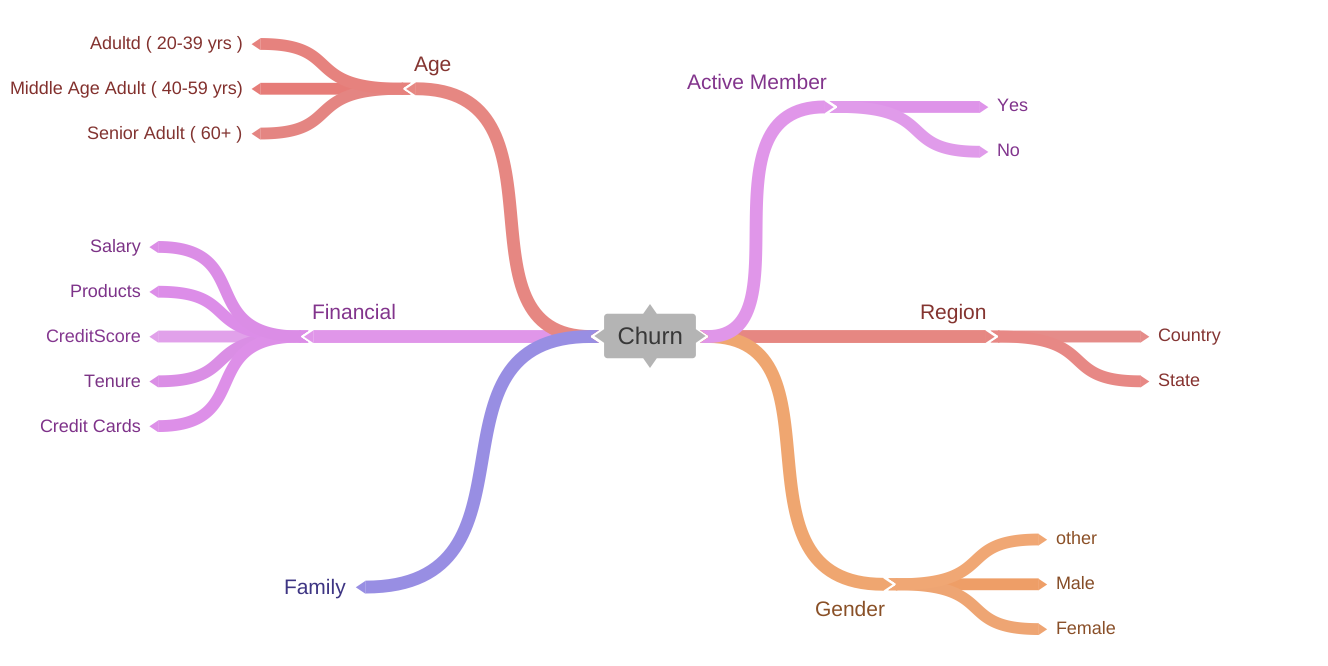

In [48]:
Image('Imgs/churn.png')

# 3.0 Data Filtering

In [49]:
df3 = df2.copy()

In [50]:
# As the number of clients is the same as the number of rows, we can drop this column
# RowNumber does not provide useful information (it is a index)
# We can also excluse surname
df3 = df3.drop(['RowNumber','CustomerId' ,'Surname'], axis = 1 )

# 4.0 EDA

## 4.1 Univariate Analysis

In [51]:
df4 = df3.copy()

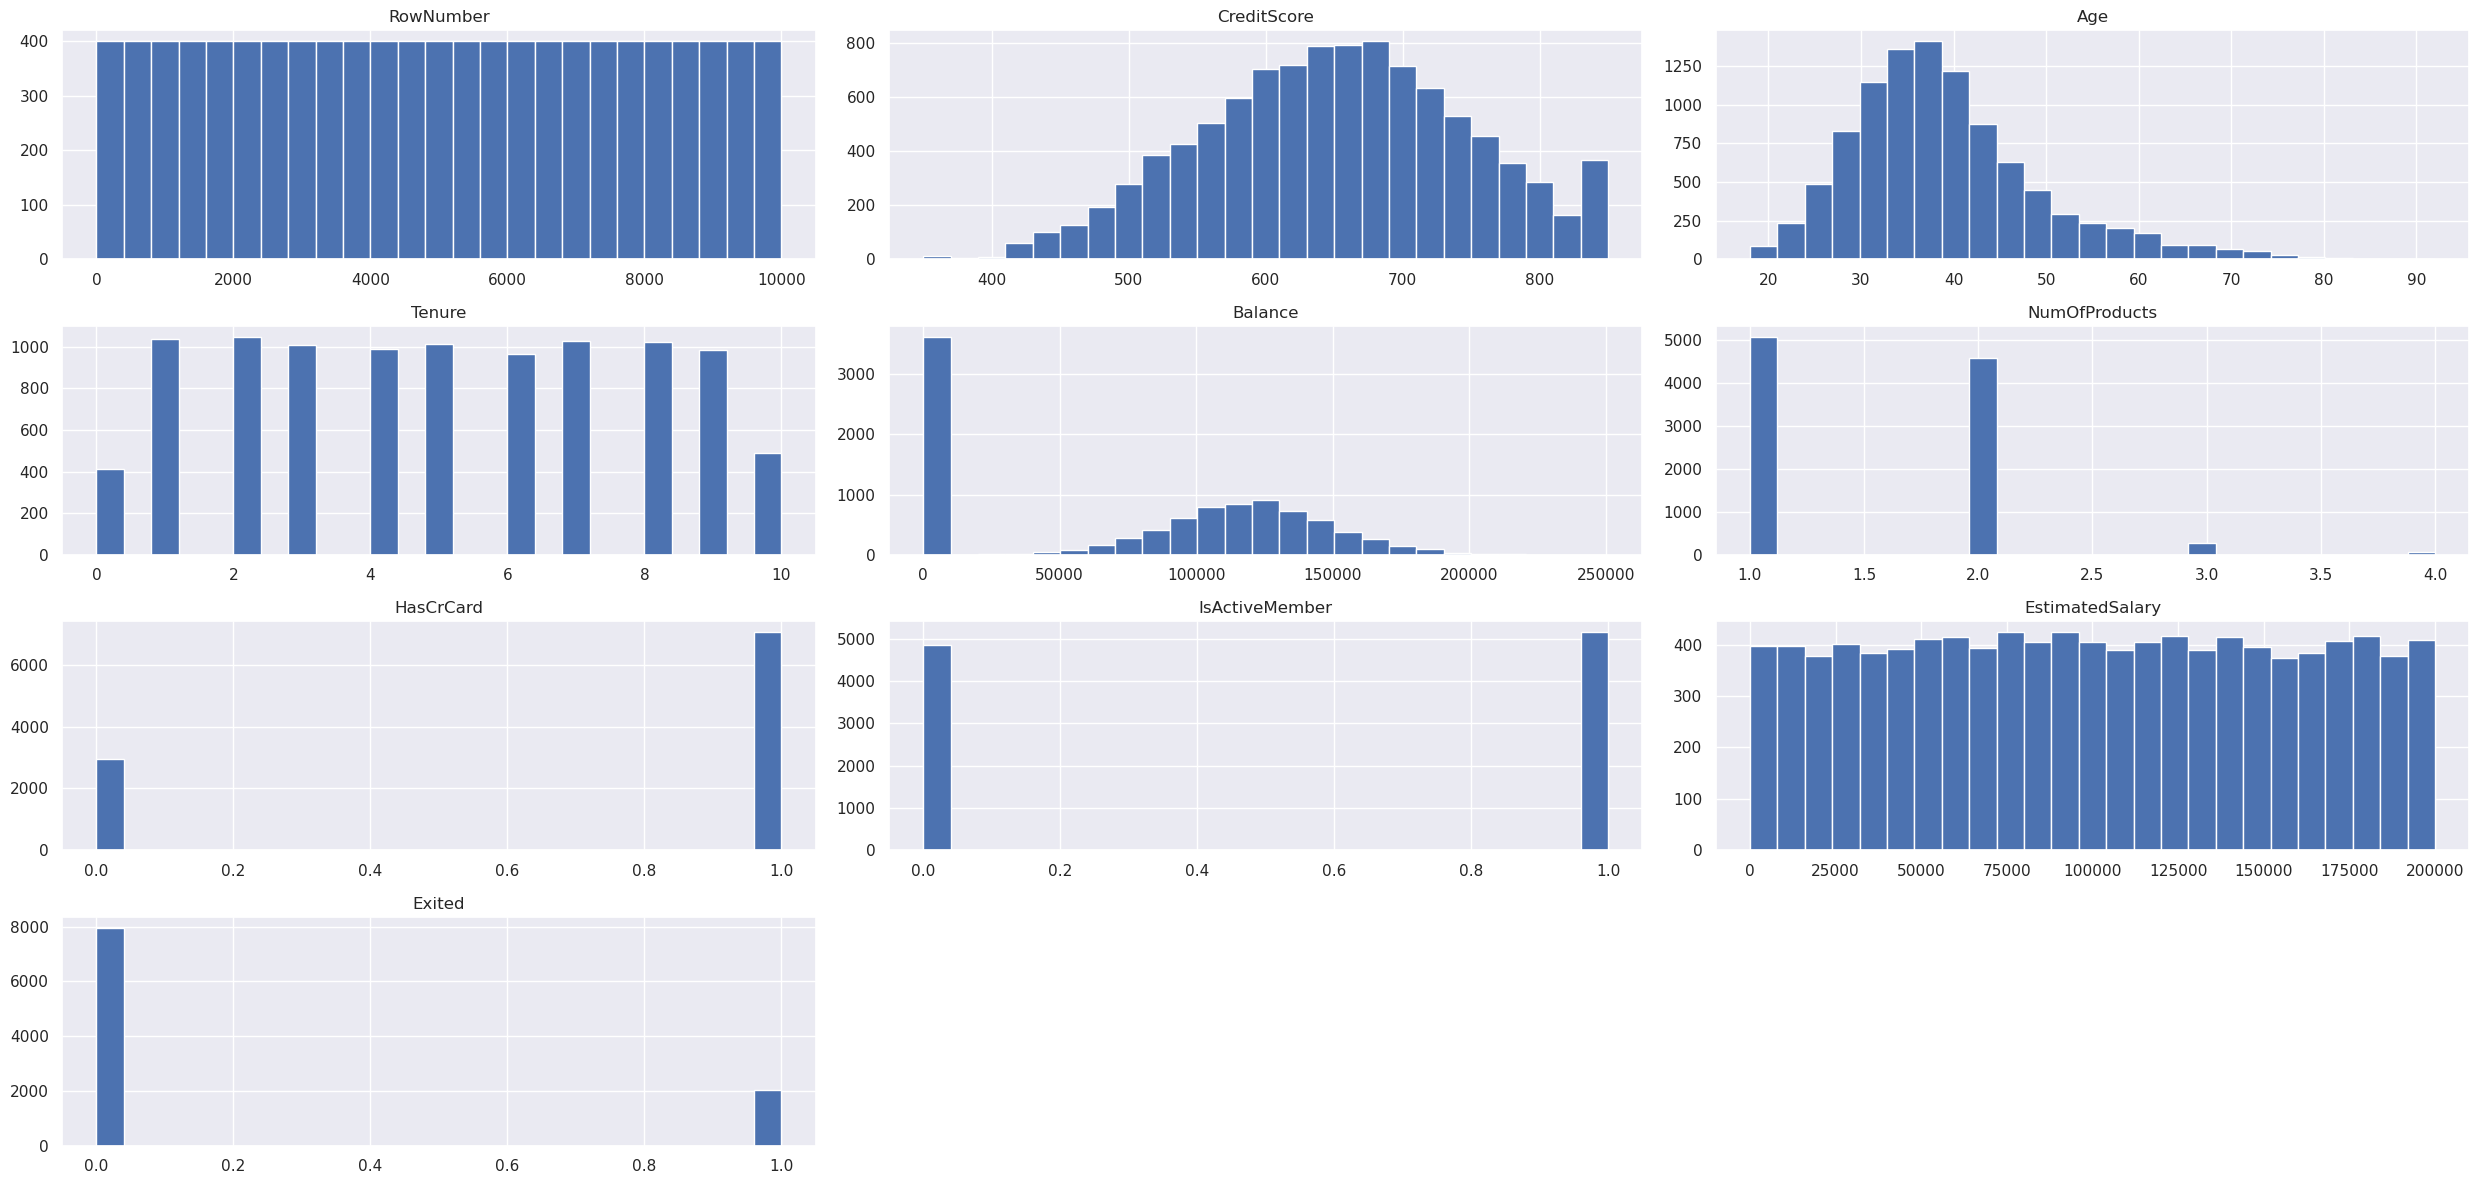

In [52]:
num_attributes.hist(bins = 25);
plt.tight_layout()

<br>

**Based on the plots below I would suggest that the most relevant features that might help our model to simulate the pattern of churn are:**
* Age
* Geography
* Number of Product
* Active Member
* Gender

Looking at the plots, we can notice different patterns and this might provide relevant information for our model.

### 4.1.1 Age

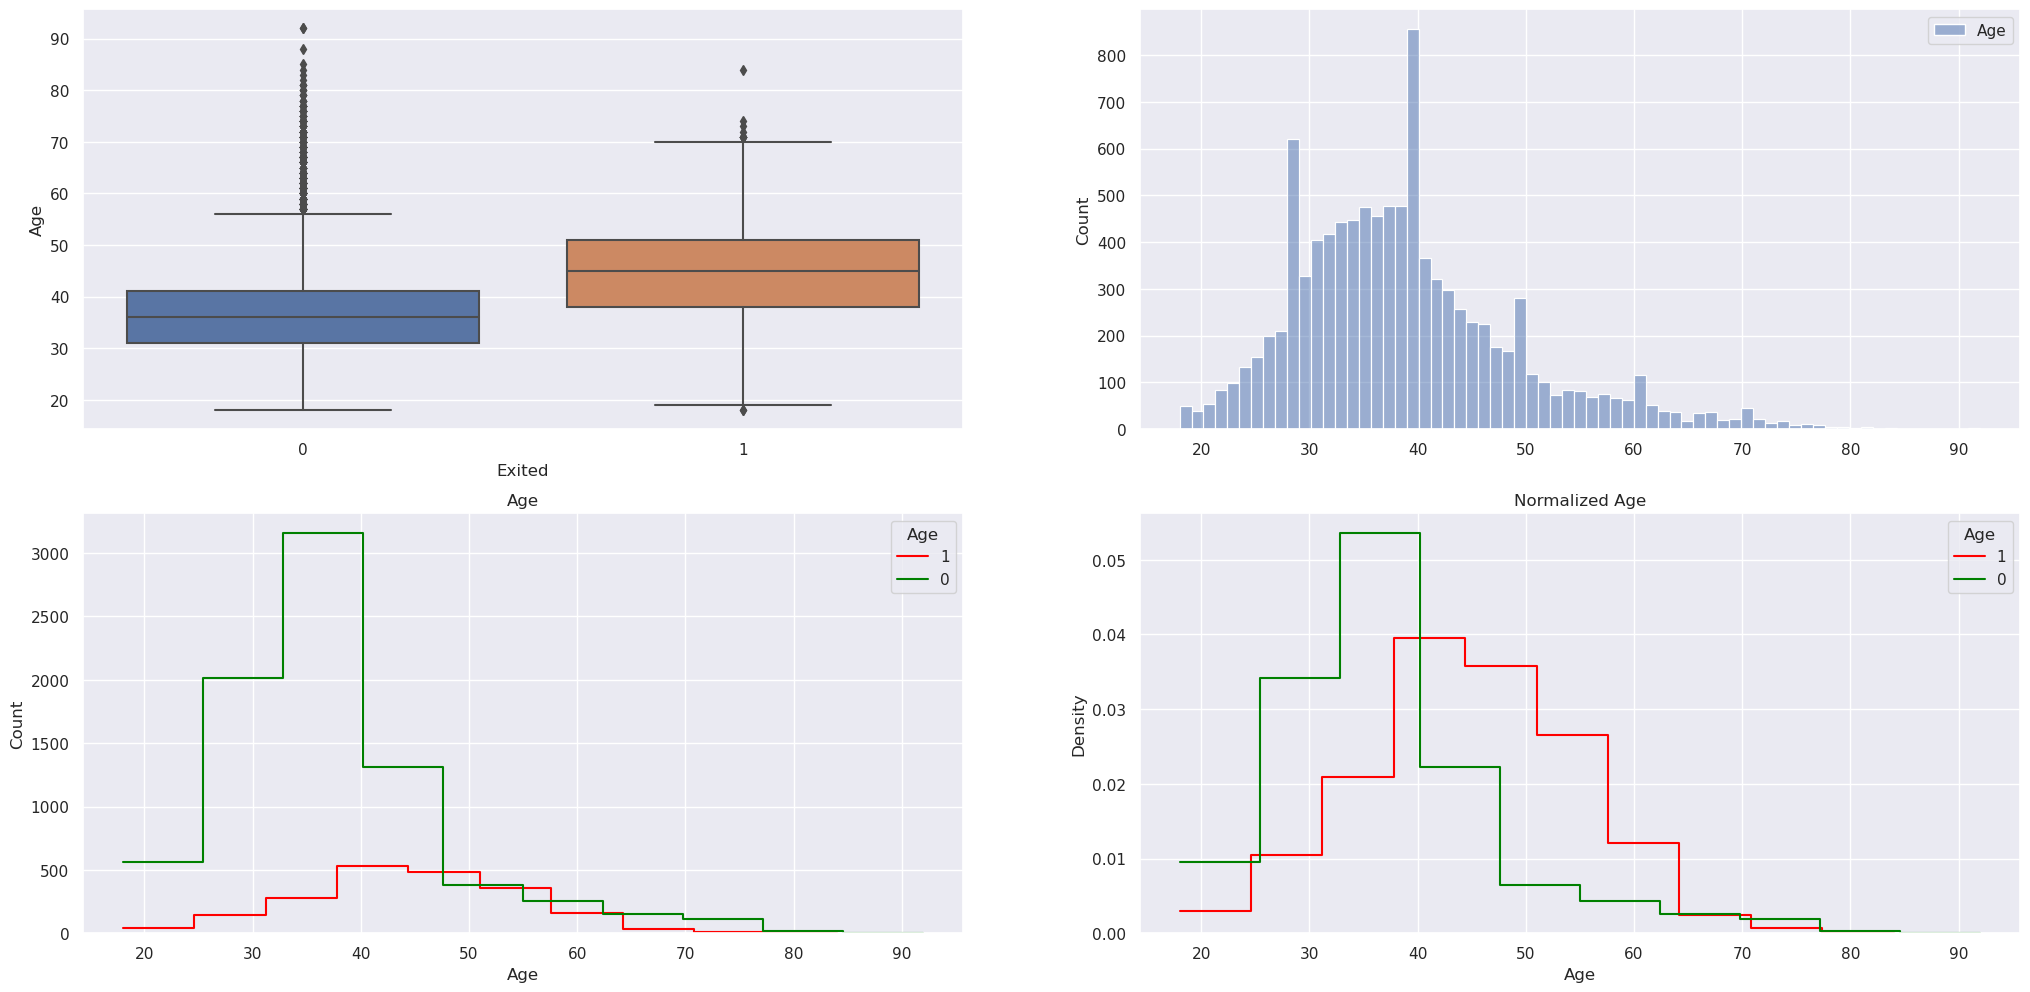

In [53]:
# age
box_dist_plots('Exited', 'Age', df4,)

* The mean age of the churned clients is higher than the mean of the not churned client 
* Age seemss to be a relevant feature

### 4.1.2 Balance

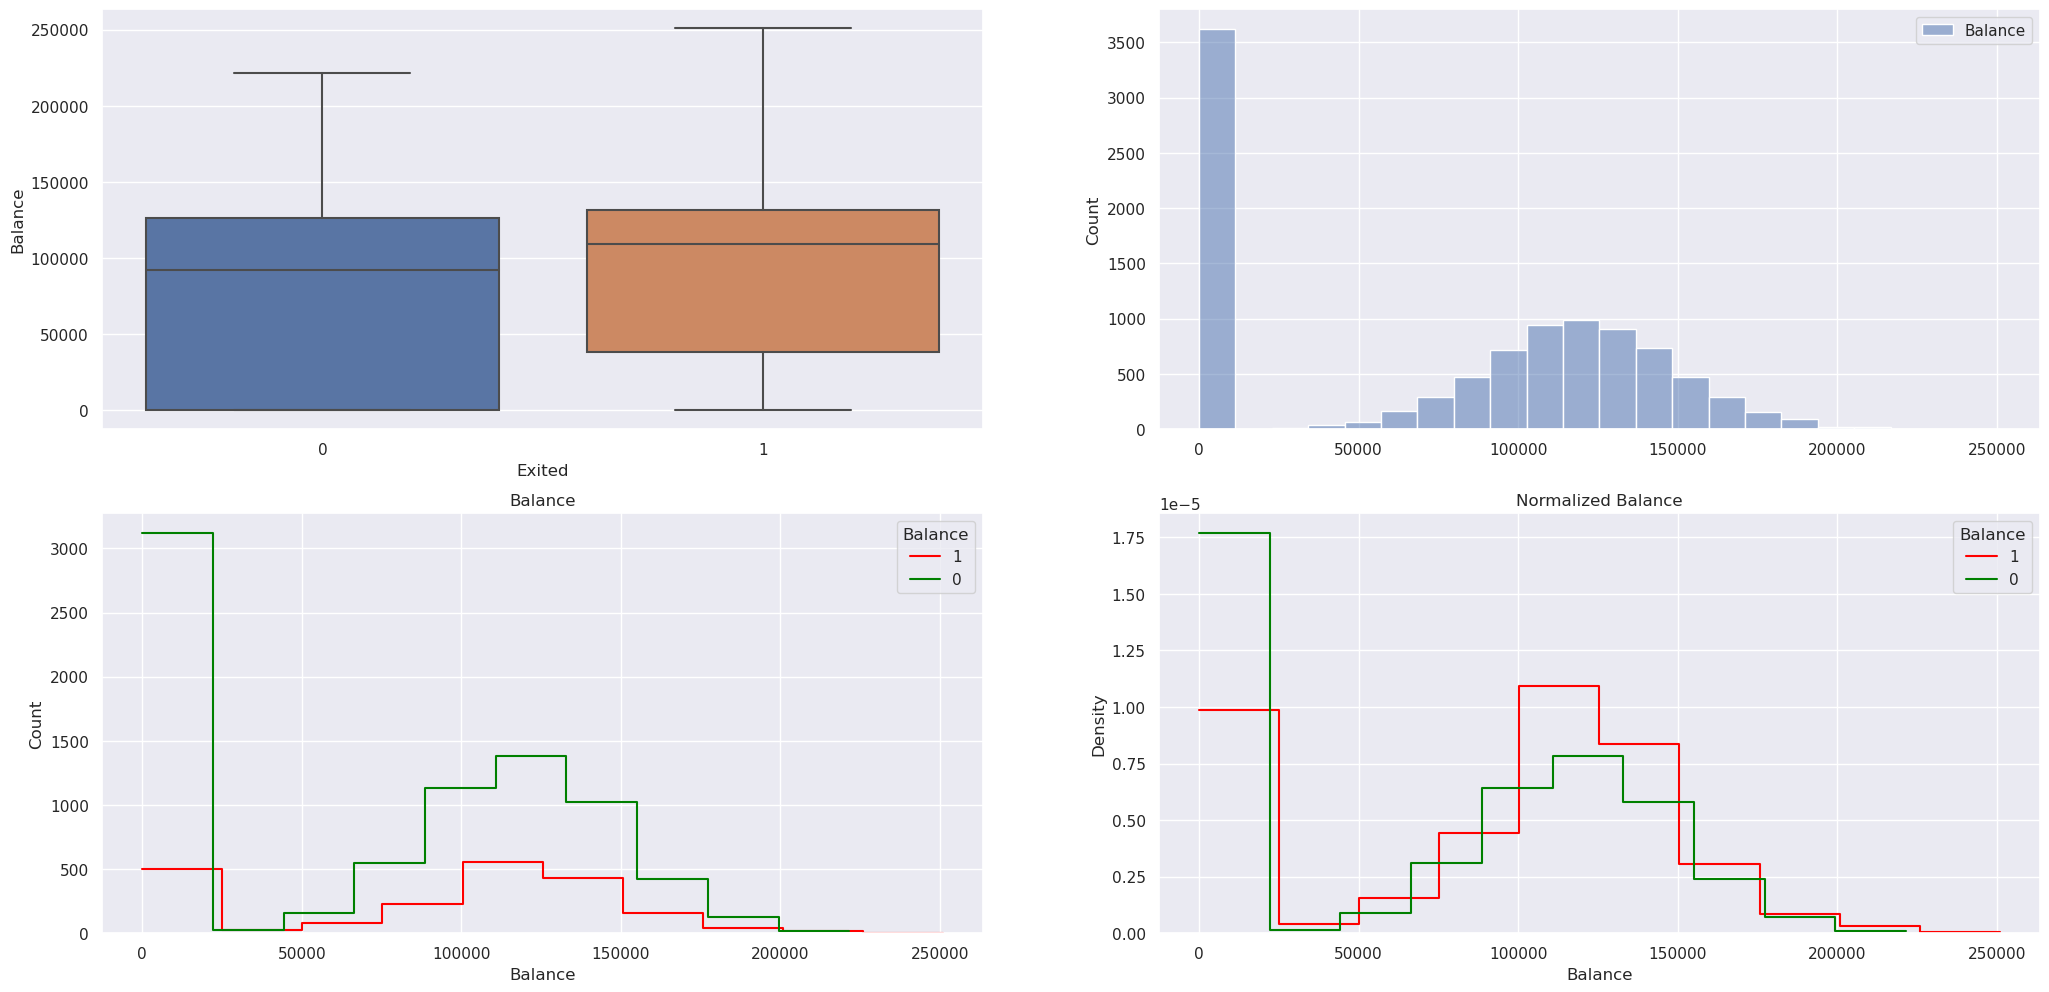

In [54]:
 box_dist_plots('Exited', 'Balance', df4,)

### 4.1.3 CreditScore

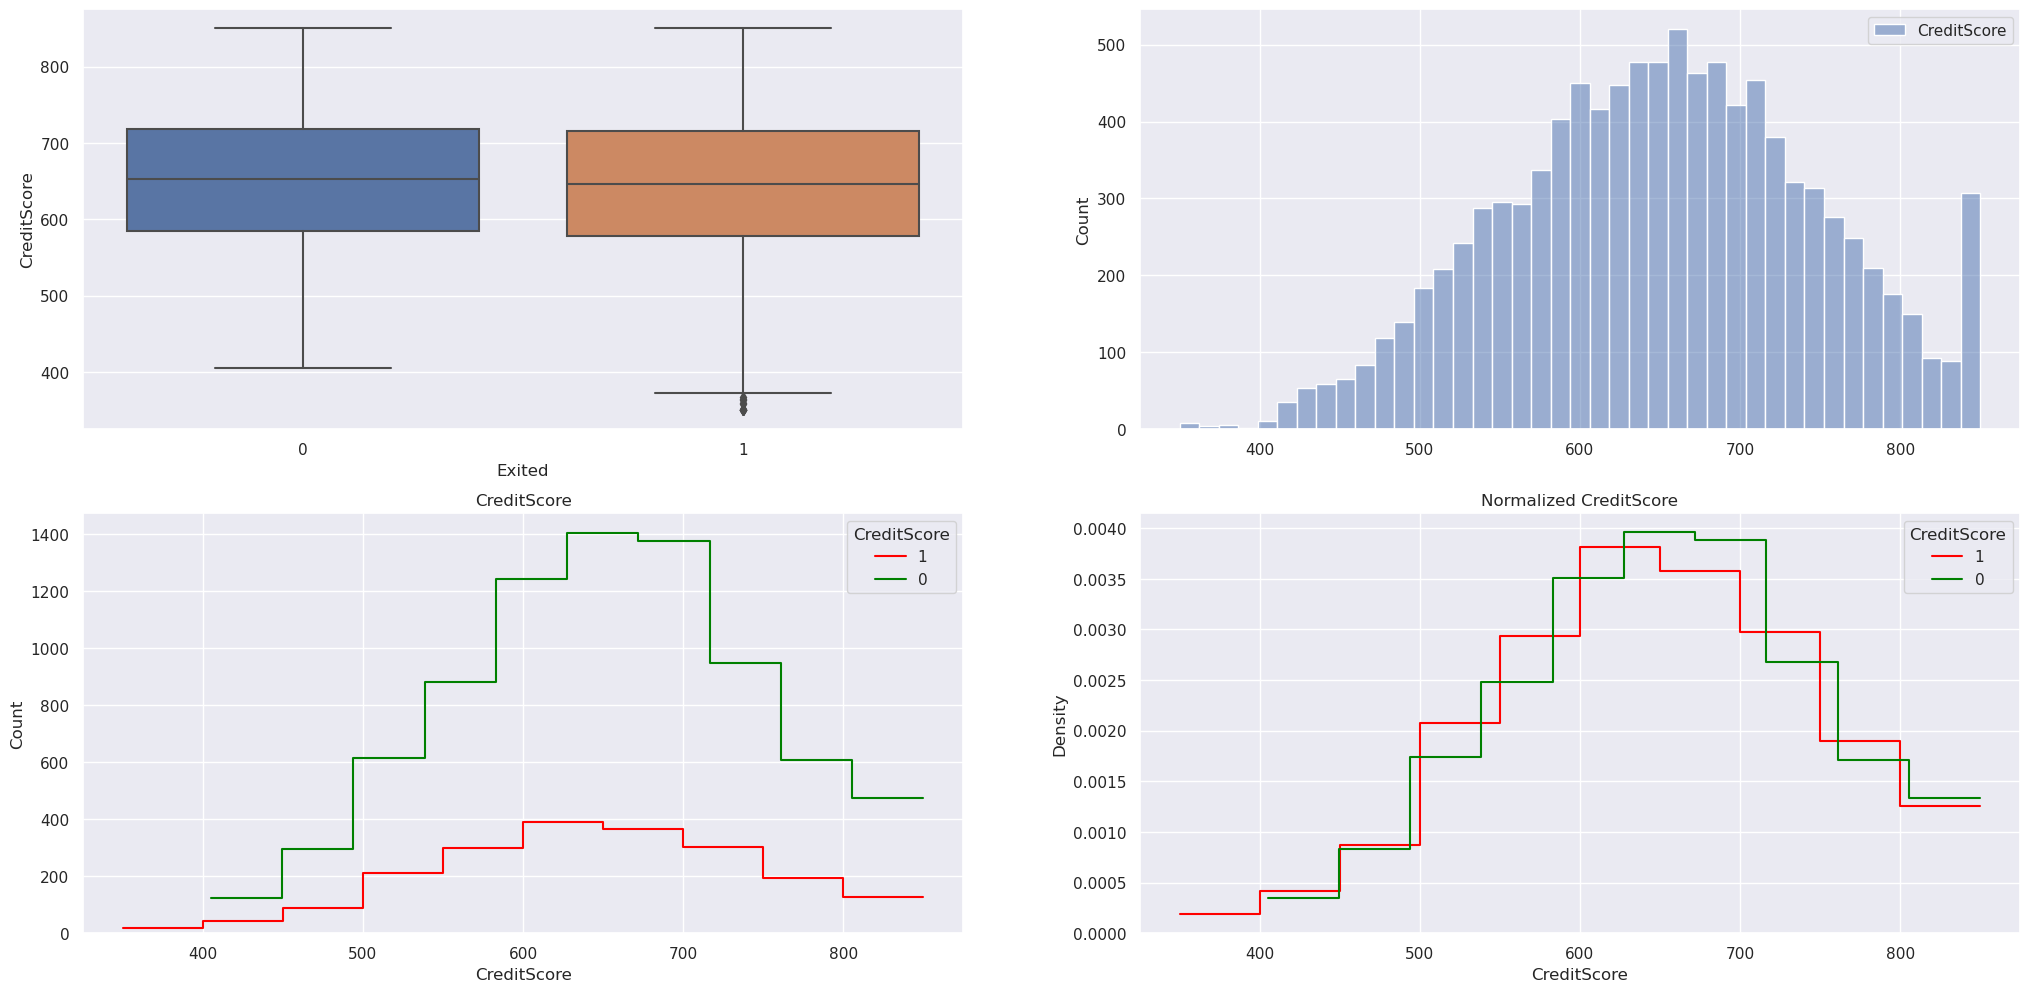

In [55]:
 box_dist_plots('Exited', 'CreditScore', df4,)

### 4.1.4 Tenure

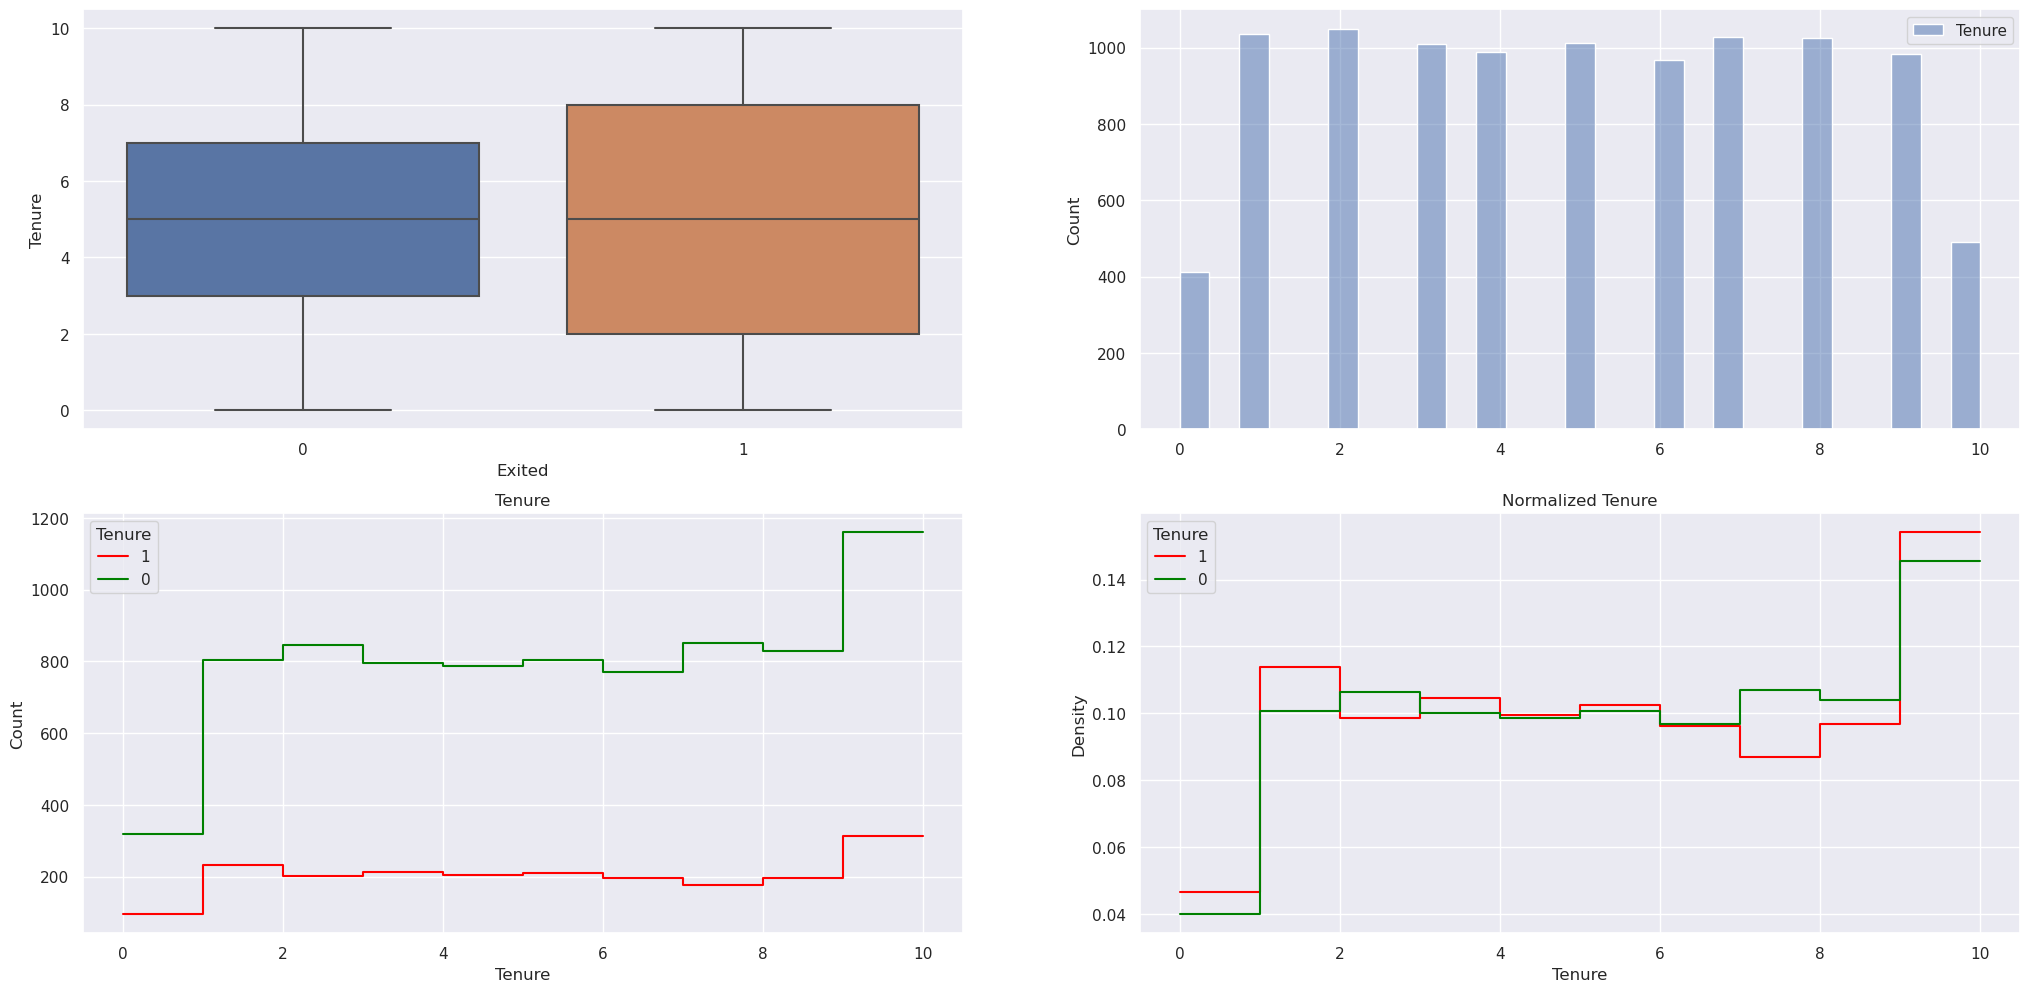

In [56]:
 box_dist_plots('Exited', 'Tenure', df4,)

### 4.1.5 Products

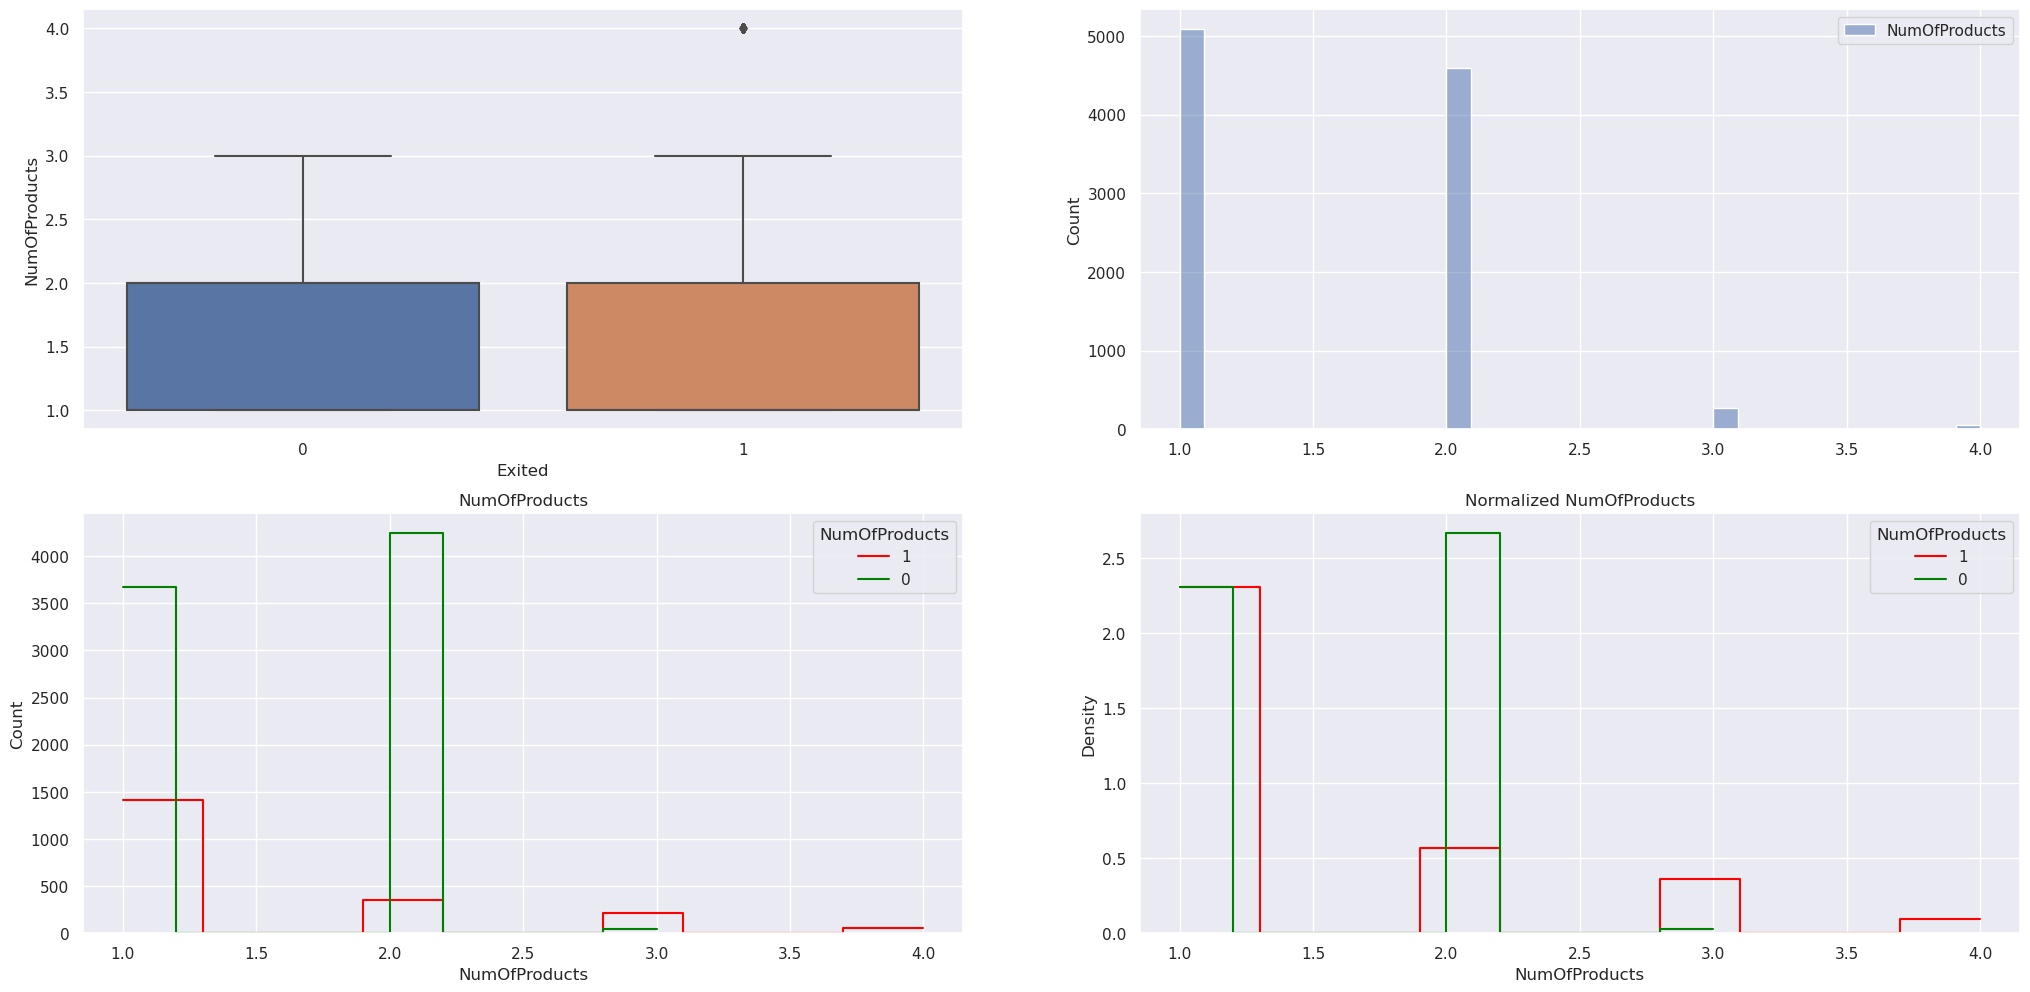

In [57]:
 box_dist_plots('Exited', 'NumOfProducts', df4,bins =1)

### 4.1.6 Salary

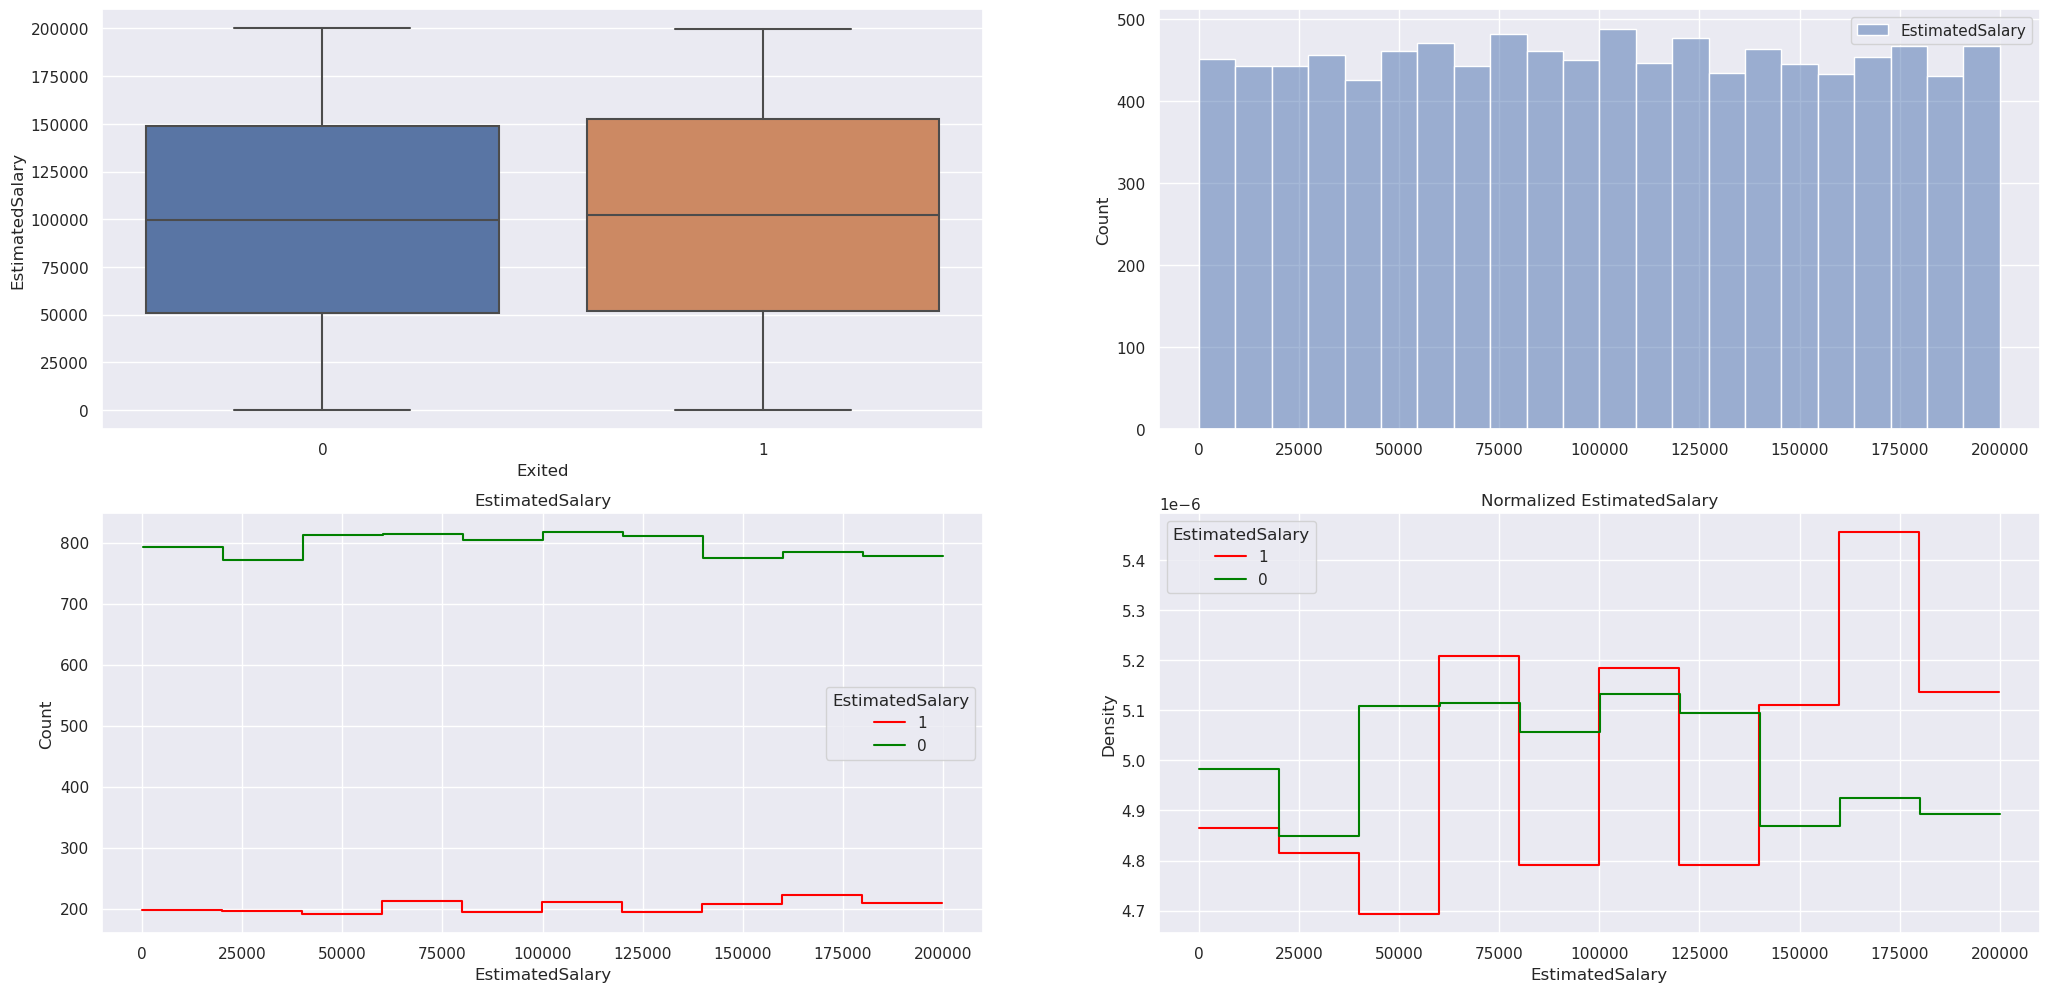

In [58]:
box_dist_plots('Exited', 'EstimatedSalary', df4)

Normalized plots due to unbalanced data

### 4.1.7 Geography - Gender - Active Member - Credit Card

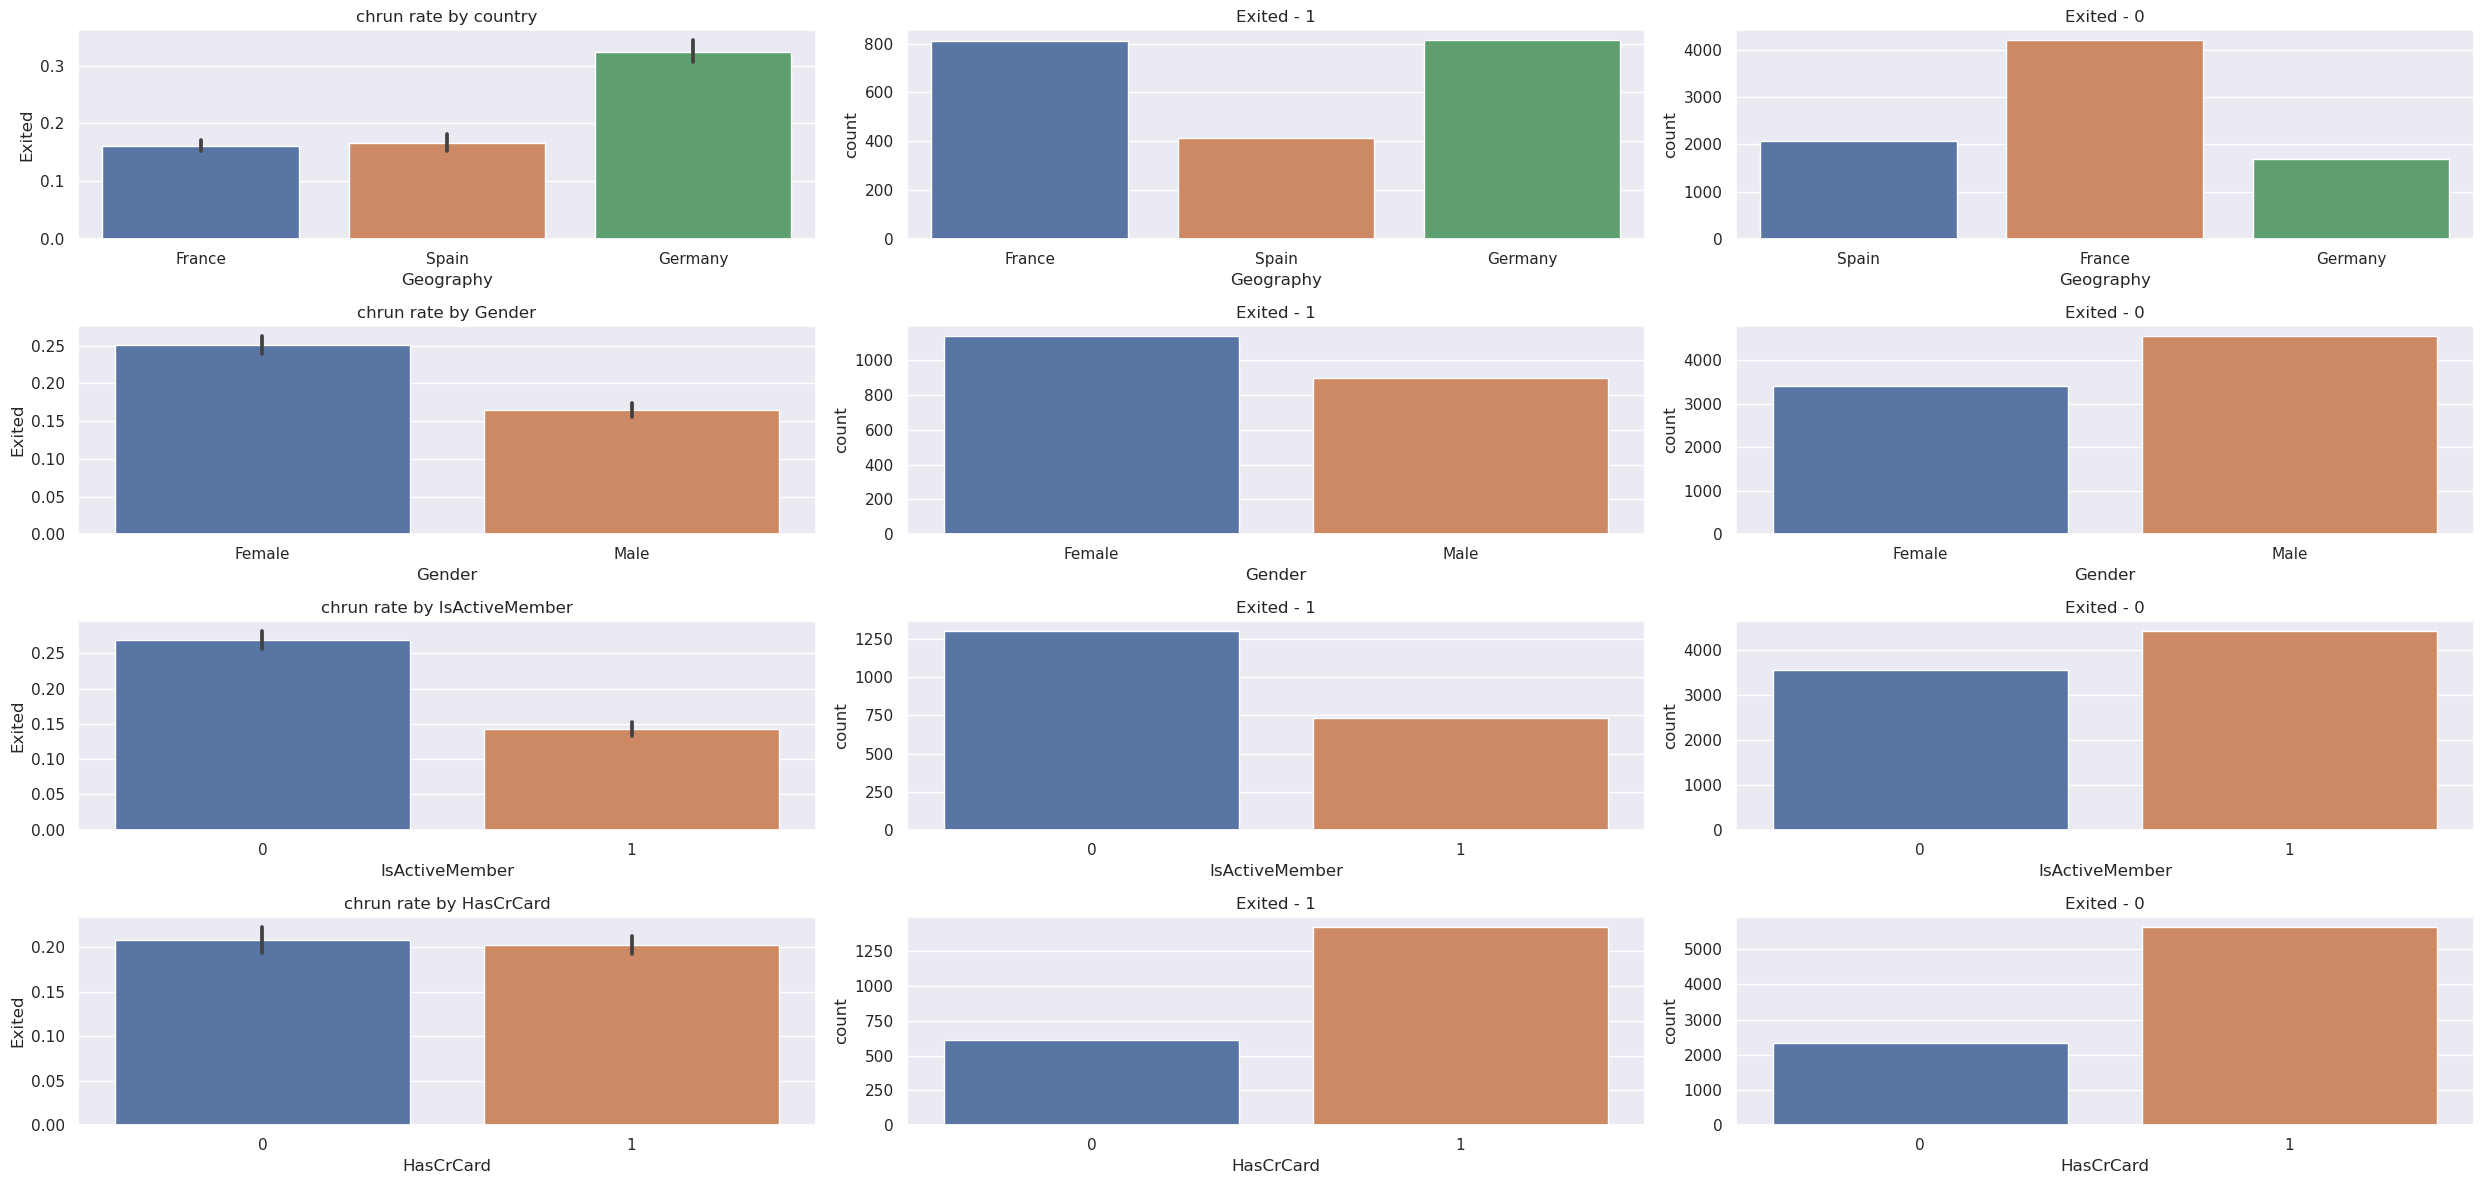

In [71]:
plt.subplot(4,3,1)
sns.barplot(data=df4, x="Geography", y="Exited")
plt.title('chrun rate by country')

plt.subplot(4,3,2)
aux = df3.loc[df4['Exited'] == 1]
sns.countplot( x = aux['Geography'] )
plt.title('Exited - 1');

plt.subplot(4,3,3)
aux = df3.loc[df4['Exited'] == 0]
sns.countplot( x = aux['Geography'] )
plt.title('Exited - 0');

plt.subplot(4,3,4)
sns.barplot(data=df4, x="Gender", y="Exited")
plt.title('chrun rate by Gender')

plt.subplot(4,3,5)
aux = df3.loc[df4['Exited'] == 1]
sns.countplot( x = aux['Gender'] )
plt.title('Exited - 1');

plt.subplot(4,3,6)
aux = df3.loc[df4['Exited'] == 0]
sns.countplot( x = aux['Gender'] )
plt.title('Exited - 0');


plt.subplot(4,3,7)
sns.barplot(data=df4, x="IsActiveMember", y="Exited")
plt.title('chrun rate by IsActiveMember')


plt.subplot(4,3,8)
aux = df3.loc[df4['Exited'] == 1]
sns.countplot( x = aux['IsActiveMember'] )
plt.title('Exited - 1');

plt.subplot(4,3,9)
aux = df3.loc[df4['Exited'] == 0]
sns.countplot( x = aux['IsActiveMember'] )
plt.title('Exited - 0');

plt.subplot(4,3,10)
sns.barplot(data=df4, x="HasCrCard", y="Exited")
plt.title('chrun rate by HasCrCard')

plt.subplot(4,3,11)
aux = df3.loc[df4['Exited'] == 1]
sns.countplot( x = aux['HasCrCard'] )
plt.title('Exited - 1');

plt.subplot(4,3,12)
aux = df3.loc[df4['Exited'] == 0]
sns.countplot( x = aux['HasCrCard'] )
plt.title('Exited - 0');

plt.tight_layout();

In [80]:
df4.head()

,RowNumber,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 4.1 Multivariate Analysis

# 5.0 Data Preparation

# 6.0 Feature Selection

# 7.0 Machine Learning

# 8.0 Hyperparameter Fine Tune

# 9.0 Error Interpreration

# 10.0 Deploy Model